In [1]:
import pandas as pd
import random
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

# Importing Data

In [2]:
data_train = pd.read_csv('Mushroom_datasets/mushroom_train.csv')
data_test = pd.read_csv('Mushroom_datasets/mushroom_test.csv')
data_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e


# Trival System

In [3]:
N = data_train.shape[0]
N1 = data_train[data_train['class']=='p'].shape[0]
N2 = data_train[data_train['class']=='e'].shape[0]
N_test = data_test['class'].shape[0]
y_pred = []

for _ in range(N_test):
    if random.random() < N1/N:
        y_pred.append('p')
    else:
        y_pred.append('e')

acc = 0
for i in range(N_test):
    if y_pred[i] == data_test['class'][i]:
        acc+=1
        
print("Accuracy of test dataset is", acc*100/N, "%")

Accuracy of test dataset is 21.596331992139984 %


In [4]:
f_score = f1_score(data_test['class'], y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.4413988076946715


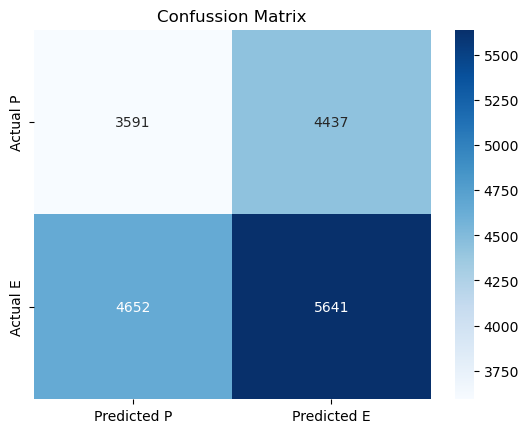

In [5]:
cm = confusion_matrix(data_test['class'], y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()

# One-Hot Encoding

In [6]:
classes = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']
for i in classes:
    print("Unique values of", i, ':', data_train[i].unique())
    data_train = pd.get_dummies(data_train, columns=[i])
    data_test = pd.get_dummies(data_test, columns=[i])

Unique values of cap-shape : ['c' 'x' 's' 'o' 'f' 'b' 'p']
Unique values of cap-surface : ['i' 'y' 't' 'd' 'g' 'h' 'k' 's' 'e' 'w' 'l']
Unique values of cap-color : ['y' 'r' 'n' 'w' 'g' 'k' 'o' 'l' 'e' 'u' 'b' 'p']
Unique values of does-bruise-or-bleed : ['f' 't']
Unique values of gill-attachment : ['a' 'd' 'p' 'x' 'e' 'f' 's']
Unique values of gill-spacing : ['c' 'd' 'f']
Unique values of gill-color : ['n' 'w' 'g' 'y' 'p' 'k' 'f' 'b' 'e' 'o' 'r' 'u']
Unique values of stem-color : ['w' 'y' 'n' 'r' 'o' 'g' 'l' 'e' 'u' 'f' 'k' 'p' 'b']
Unique values of has-ring : ['f' 't']
Unique values of ring-type : ['f' 'r' 'e' 'z' 'l' 'p' 'g' 'm']
Unique values of habitat : ['d' 'h' 'g' 'l' 'm' 'w' 'p' 'u']
Unique values of season : ['a' 'u' 'w' 's']


In [7]:
data_train.head()

,cap-diameter,stem-height,stem-width,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,...,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,4.98,6.04,6.21,p,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2.84,5.66,3.55,p,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,11.44,7.03,25.29,e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,8.77,4.44,13.61,p,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,7.55,8.41,18.44,e,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# Baseline System

In [8]:
X_train = data_train.drop('class', axis=1)
y_train = data_train['class']
X_test = data_test.drop('class', axis=1)
y_test = data_test['class']
class_means = X_train.groupby(y_train).mean()
    
y_pred = []
class_labels = class_means.index.values
for i in range(len(X_test)):
    distances = []
    for j in range(len(class_means)):
        dist = euclidean(X_test.iloc[i], class_means.iloc[j])
        distances.append(dist)
    pred_idx = distances.index(min(distances))
    pred_label = class_labels[pred_idx]
    y_pred.append(pred_label)
    
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of test dataset:", accuracy*100, "%")

Accuracy of test dataset: 60.34605097975001 %


In [9]:
f_score = f1_score(y_test, y_pred, pos_label='e')
print("F1 score:", f_score)

F1 score: 0.5364639826453136


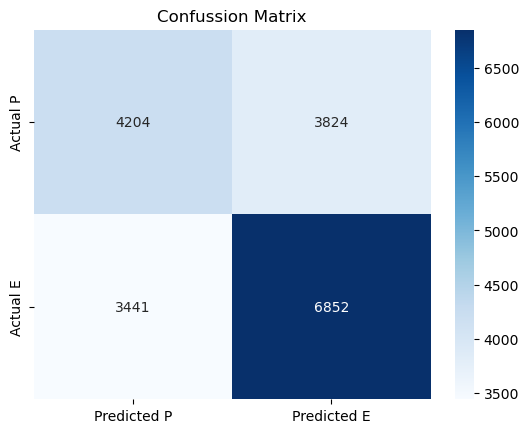

In [10]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual P', 'Actual E'], columns=['Predicted P', 'Predicted E'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title("Confussion Matrix")
plt.show()